In [63]:
!pip install tqdm
!pip install statsmodels
!pip install matplotlib
!pip install tensorflow
!pip install seaborn
!pip install scikit-learn

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/20/cf/55b68d5896e58e25f41e5bc826c96678073b512be8ca2b1f4b101e0f195c/tensorflow-2.19.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/8f/aa/ba0014cc4659328dc818a28827be78e6d97312ab0cb98105a770924dc11e/absl_py-2.3.1-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=24.3.25 from https://files.pythonhosted.org/packages/b8/25/155f9f080d5e4bc0082edfda032ea2bc2b8fab3f4d25d46c1e9dd22a1a89/flatbuffers-25.2.10-py2.py3-none-any.whl.metadata
  Obtaining dependency information for gast!=0.5.0,!=0.5.1,!=0.5.2,>=0.2.1 from https://files.pythonhosted.org/packages/a3/61/8001b38

In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
import seaborn as sns
from math import sqrt
import itertools
import re
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rcParams
mpl.rc('font', family='AppleGothic')
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.unicode_minus'] = False

In [30]:
data = pd.read_csv('train.csv')

In [31]:
data

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,75,198,4,391.0,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093.0,421.0
1201,2021-01-21,목,2983,92,231,462,351.0,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832.0,353.0
1202,2021-01-22,금,2983,255,248,1,303.0,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579.0,217.0
1203,2021-01-25,월,2983,107,153,616,327.0,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145.0,502.0


In [32]:
# 일자 관련 변수
year = []
for i in range(len(data['일자'])) :
    year.append(data.iloc[i,0][0:4])
data['year'] = year

In [33]:
mon = []
for i in range(len(data['일자'])) :
    mon.append(data.iloc[i,0][5:7])
data['월'] = mon

In [34]:
date = []
for i in range(len(data['일자'])) :
    date.append(data.iloc[i,0][8:10])
data['date'] = date

In [35]:
yoil = []
for i in range(len(data)) :
    if data.iloc[i,1] == '월' : yoil.append(0)
    if data.iloc[i,1] == '화' : yoil.append(1)
    if data.iloc[i,1] == '수' : yoil.append(2)
    if data.iloc[i,1] == '목' : yoil.append(3)
    if data.iloc[i,1] == '금' : yoil.append(4)
data['요일'] = yoil

In [36]:
# 랜덤 포레스트에서 categorical로 처리하기 위해 데이터 형변환
data['date'] = data['date'].astype(int)
data['월'] = data['월'].astype(int)
data['year'] = data['year'].astype(int)

In [37]:
# 필요한 컬럼 선택
data = data[['일자','year','월','date','요일','본사정원수','본사휴가자수','본사출장자수','본사시간외근무명령서승인건수','현본사소속재택근무자수','중식메뉴','중식계']]

In [38]:
data

,일자,year,월,date,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,중식계
0,2016-02-01,2016,2,1,0,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...",1039.0
1,2016-02-02,2016,2,2,1,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...",867.0
2,2016-02-03,2016,2,3,2,2601,56,180,111,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...",1017.0
3,2016-02-04,2016,2,4,3,2601,104,220,355,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...",978.0
4,2016-02-05,2016,2,5,4,2601,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...",925.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,2021,1,20,2,2983,75,198,4,391.0,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,1093.0
1201,2021-01-21,2021,1,21,3,2983,92,231,462,351.0,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,832.0
1202,2021-01-22,2021,1,22,4,2983,255,248,1,303.0,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,579.0
1203,2021-01-25,2021,1,25,0,2983,107,153,616,327.0,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,1145.0


In [39]:
import re

In [40]:
def make_menu_token(data):
    main_menu_1 = []
    main_menu_2 = []
    main_menu_3 = []

    for idx in range(len(data)):
        #중식메뉴 문자열을 공백 기준으로 나눈 뒤, 빈 항목 제거
        tmp = data.loc[idx, '중식메뉴'].split()

        cleaned_menu = []
        for menu in tmp:
            # 괄호 안 정보 다 제거
            menu_cleaned = re.sub(r'\(.*?\)', '', menu).strip()
            if menu_cleaned:
                #공백이 아닌경우에만 추가
                cleaned_menu.append(menu_cleaned)
        # 3개의 메인메뉴가 존재한다고 가정
        main_menu_1.append(cleaned_menu[0] if len(cleaned_menu) > 0 else '')
        main_menu_2.append(cleaned_menu[1] if len(cleaned_menu) > 1 else '')
        main_menu_3.append(cleaned_menu[2] if len(cleaned_menu) > 2 else '')

    data['메인메뉴1'] = main_menu_1
    data['메인메뉴2'] = main_menu_2
    data['메인메뉴3'] = main_menu_3

make_menu_token(data)

In [41]:
##실질 인원 산출 후 실질인원 대비 중식계의 비율을 식사비율로 정의
data['실질인원'] = data['본사정원수'] - data['본사휴가자수'] - data['본사출장자수'] - data['현본사소속재택근무자수']
data['식사비율'] = data['중식계'] / data['실질인원']

In [42]:
menu_scores = []

# 메뉴와 위치 정보
menu_columns = ['메인메뉴1','메인메뉴2', '메인메뉴3']
for col in menu_columns:
    tmp_df = data[[col, '식사비율']].copy()
    tmp_df.columns = ['중식메뉴', '식사비율']
    menu_scores.append(tmp_df)


In [43]:
all_menu_demand = pd.concat(menu_scores)

In [44]:
#메뉴별 평균 demand 계산(선호도)
menu_preference = all_menu_demand.groupby('중식메뉴').mean().sort_values(by='식사비율', ascending=False)
menu_preference = menu_preference.reset_index()
menu_preference.columns = ['메뉴명', '선호지수']
menu_preference

,메뉴명,선호지수
0,가래떡돼지갈비찜,0.592144
1,삼겹살김치볶음,0.584035
2,누룽지장각백숙,0.580096
3,캔꽁치튀김,0.580096
4,소고기떡국,0.571138
...,...,...
725,야채볶음밥*짜장소스,0.211965
726,해물수제비국,0.199380
727,수제탕수육,0.196911
728,감자양파국,0.191405


In [45]:
# 선호지수를 원래 데이터에 매핑
## 메뉴-점수 매핑 딕셔너리 생성
score_map = dict(zip(menu_preference['메뉴명'], menu_preference['선호지수']))

In [46]:
## 점수 칼럼 추가
data['메인메뉴1_선호지수'] = data['메인메뉴1'].map(score_map)
data['메인메뉴2_선호지수'] = data['메인메뉴2'].map(score_map)
data['메인메뉴3_선호지수'] = data['메인메뉴3'].map(score_map)

data = data[['year','월','date','요일','실질인원','메인메뉴1','메인메뉴2','메인메뉴3','메인메뉴1_선호지수', '메인메뉴2_선호지수', '메인메뉴3_선호지수','식사비율']]
data

,year,월,date,요일,실질인원,메인메뉴1,메인메뉴2,메인메뉴3,메인메뉴1_선호지수,메인메뉴2_선호지수,메인메뉴3_선호지수,식사비율
0,2016,2,1,0,2401.0,쌀밥/잡곡밥,오징어찌개,쇠불고기,0.379554,0.432736,0.435412,0.432736
1,2016,2,2,1,2378.0,쌀밥/잡곡밥,김치찌개,가자미튀김,0.379554,0.392490,0.325286,0.364592
2,2016,2,3,2,2365.0,카레덮밥,팽이장국,치킨핑거,0.366182,0.374659,0.353322,0.430021
3,2016,2,4,3,2277.0,쌀밥/잡곡밥,쇠고기무국,주꾸미볶음,0.379554,0.390525,0.337742,0.429513
4,2016,2,5,4,2142.0,쌀밥/잡곡밥,떡국,돈육씨앗강정,0.379554,0.395263,0.431839,0.431839
...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021,1,20,2,2319.0,쌀밥/흑미밥/찰현미밥,아욱국,수제함박스테이크,0.393360,0.373795,0.471324,0.471324
1201,2021,1,21,3,2309.0,쌀밥/수수밥/찰현미밥,냉이된장국,동파육,0.372526,0.370020,0.399378,0.360329
1202,2021,1,22,4,2177.0,전주비빔밥*약고추장,계란파국,요거닭,0.265962,0.265962,0.265962,0.265962
1203,2021,1,25,0,2396.0,쌀밥/흑미밥/찰현미밥,전주식콩나물해장국,돈육간장불고기,0.393360,0.477880,0.485043,0.477880


statsmodels library 사용하여 회귀분석 진행

In [47]:
# 학습/테스트 세트 분리
train = data.iloc[:-300].copy()
test = data.iloc[-300:].copy()

In [48]:
test

,year,월,date,요일,실질인원,메인메뉴1,메인메뉴2,메인메뉴3,메인메뉴1_선호지수,메인메뉴2_선호지수,메인메뉴3_선호지수,식사비율
905,2019,10,21,0,2726.0,쌀밥/잡곡밥,고추장찌개,훈제오리단호박볶음,0.379554,0.359012,0.406090,0.406090
906,2019,10,22,1,2644.0,쌀밥/잡곡밥,얼큰순두부찌개,짬뽕불고기,0.379554,0.357656,0.390308,0.412254
907,2019,10,23,2,2746.0,카레라이스,우동국,유린기,0.362552,0.285870,0.330575,0.285870
908,2019,10,24,3,2679.0,쌀밥/잡곡밥,건새우아욱국,등갈비김치말이,0.379554,0.300987,0.310509,0.263158
909,2019,10,25,4,2482.0,나물비빔밥,팽이장국,생선까스*칠리소스,0.361996,0.374659,0.289600,0.219984
...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021,1,20,2,2319.0,쌀밥/흑미밥/찰현미밥,아욱국,수제함박스테이크,0.393360,0.373795,0.471324,0.471324
1201,2021,1,21,3,2309.0,쌀밥/수수밥/찰현미밥,냉이된장국,동파육,0.372526,0.370020,0.399378,0.360329
1202,2021,1,22,4,2177.0,전주비빔밥*약고추장,계란파국,요거닭,0.265962,0.265962,0.265962,0.265962
1203,2021,1,25,0,2396.0,쌀밥/흑미밥/찰현미밥,전주식콩나물해장국,돈육간장불고기,0.393360,0.477880,0.485043,0.477880


In [50]:
#필요한 열만 추출
features = ['year', '월', '요일', '메인메뉴1_선호지수', '메인메뉴2_선호지수','메인메뉴3_선호지수']
target = '식사비율'

# 시차 변수는 첫 번째 행에서 NaN 발생 -> 제거
train = train.dropna()
test = test.dropna()

# 모델 입력값 구성
X_train_raw = train[features]
X_test_raw = test[features]
y_train = train['식사비율']
y_test = test['식사비율']

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

#데이터 프레임으로 다시 변환
X_train = pd.DataFrame(X_train_scaled, columns=features, index = X_train_raw.index)
X_test = pd.DataFrame(X_test_scaled, columns=features, index=X_test_raw.index)

#상수항추가(회귀분석의 절편 베티를 추정하기 위해)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

회귀 모델 학습 및 예측

In [52]:
#회귀 모델 학습
model = sm.OLS(y_train, X_train)
results = model.fit()

#결과 요약
print(results.summary())

#예측
y_pred = results.predict(X_test)

                            OLS Regression Results                            
Dep. Variable:                   식사비율   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     341.5
Date:                Mon, 21 Jul 2025   Prob (F-statistic):          9.12e-228
Time:                        18:23:59   Log-Likelihood:                 1523.3
No. Observations:                 905   AIC:                            -3033.
Df Residuals:                     898   BIC:                            -2999.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3813      0.002    254.217      0.0

성능 평가

In [53]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE   (평균 절대 오차):    {mae:.2f}")
print(f"RMSE  (평균 제곱근 오차):   {rmse:.2f}")
print(f"R^2   (설명력):          {r2:.4f}")

MAE   (평균 절대 오차):    0.05
RMSE  (평균 제곱근 오차):   0.00
R^2   (설명력):          0.5195


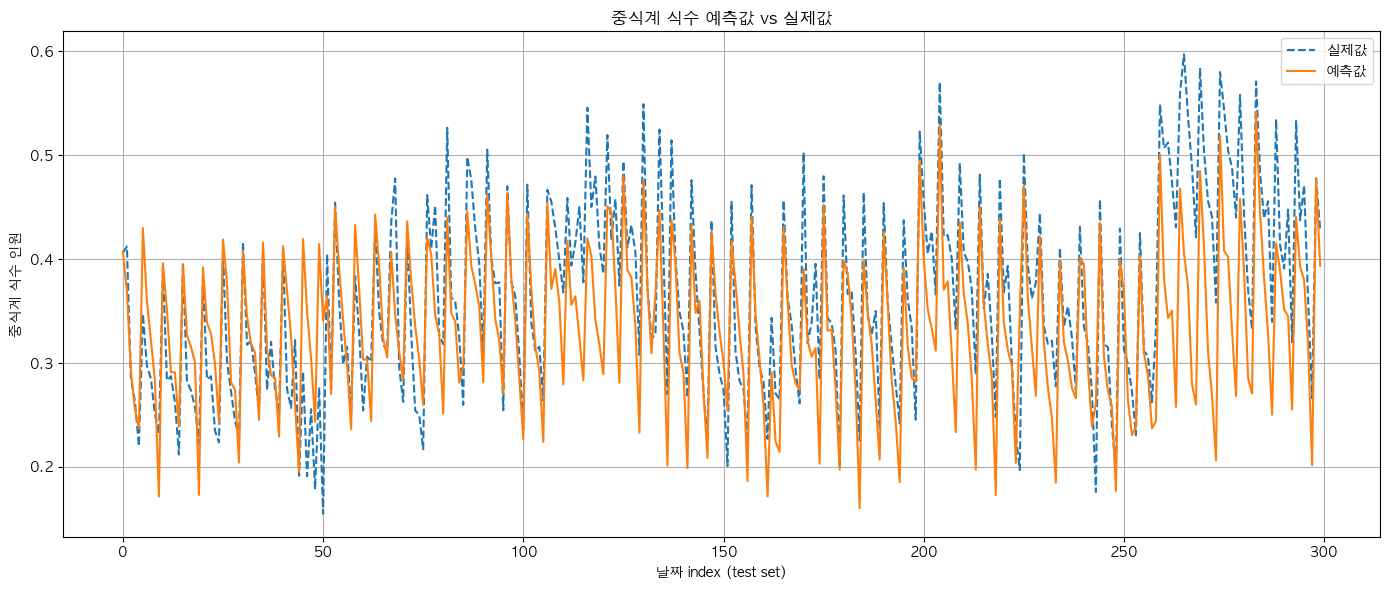

In [63]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='실제값', linestyle='--')
plt.plot(y_pred.values, label='예측값', linestyle='-')
plt.title('중식계 식수 예측값 vs 실제값')
plt.xlabel('날짜 index (test set)')
plt.ylabel('중식계 식수 인원')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()